<a href="https://colab.research.google.com/github/puraminy/mini_proj3/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Alphabets Dataset

Cloning into 'mini_proj3'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 170 (delta 17), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (170/170), 6.31 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (82/82), done.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((500, 784), (500,), 7, 0)

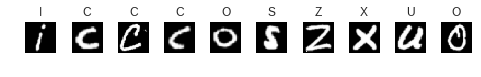

In [1]:
#!git clone "https://github.com/puraminy/mini_proj3"
!rm -r 'mini_proj3'
!git clone "https://github.com/puraminy/mini_proj3"
from mini_proj3.mysom import MiniSom

import numpy as np
alphabet = np.load('mini_proj3/Alphabets.npy')
label = np.load('mini_proj3/Alphabet_labels.npy')
label2 = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z']


import matplotlib.pyplot as plt
idx = np.random.randint(499, size=10)

fig, axes = plt.subplots(1, 10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.5)

# for i in range(len(alphabet)):
#   alphabet[i] = alphabet[i] * (255.0 / alphabet[i].max())

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
alphabet = sc.fit_transform(alphabet)
  
pltalpha = alphabet[idx,:]
pltlbl = label[idx]

for i in range(10):
  axes[i].imshow(-1*np.reshape(pltalpha[i,:],[28,28]))
  axes[i].axis('off')
  xlabel = label2[pltlbl[i]]; axes[i].set_title(xlabel)



alphabet.shape, label.shape, max(label), min(label)


#SOM

##Constant Parameters

In [2]:
features = 28*28
learningrate = 1
# ini_weights (1) PCA
#som0 = MiniSom(x=25, y=25, input_len=features)  # initialization of 25x25 SOM
#som0.pca_weights_init(alphabet)
#ini_weights = som0._weights.copy()

# ini_weights (2) Distribute from min to max value of input data [0:1]    
#ini_weights = np.expand_dims(np.linspace(0, 1, x*y),axis=1)*np.ones([1,features])
#ini_weights = np.reshape(ini_weights, [x, y, features])

# ini_weights (3) Input mean values    
#ini_weights = np.expand_dims(np.mean(alphabet,axis=0),axis=1)*np.ones([1,x*y])
#ini_weights = np.reshape(weights, [x, y, features])

# ini_weights (4) Random
#ini_weights = np.random.random([x,y,features])
som0 = MiniSom(x=25, y=25, input_len=features)  # initialization of 25x25 SOM
som0.random_weights_init(alphabet)
ini_weights = som0._weights.copy()

# ini_weights (5) Zeros
#ini_weights = np.zeros([x,y,features])

# ini_weights (6) Ones
#ini_weights = np.ones([x,y,features])
print(ini_weights)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [3]:
max_iter = 50
learning_rate = 1
eta = learning_rate
for t in range(max_iter):
  eta1 = learning_rate / (1+t/(max_iter/2))
  eta2 = learning_rate * np.exp(-t / max_iter)
  eta3 = learning_rate * np.exp(-t*0.01)

  print(eta3)

1.0
0.9900498337491681
0.9801986733067553
0.9704455335485082
0.9607894391523232
0.951229424500714
0.9417645335842487
0.9323938199059483
0.9231163463866358
0.9139311852712282
0.9048374180359595
0.8958341352965282
0.8869204367171575
0.8780954309205613
0.8693582353988059
0.8607079764250578
0.8521437889662113
0.8436648165963837
0.835270211411272
0.8269591339433623
0.8187307530779818
0.8105842459701871
0.8025187979624785
0.794533602503334
0.7866278610665535
0.7788007830714049
0.7710515858035663
0.7633794943368531
0.7557837414557255
0.7482635675785653
0.7408182206817179
0.7334469562242892
0.7261490370736909
0.7189237334319262
0.7117703227626097
0.7046880897187134
0.697676326071031
0.6907343306373547
0.6838614092123558
0.6770568744981647
0.6703200460356393
0.6636502501363194
0.6570468198150567
0.6505090947233165
0.6440364210831414
0.6376281516217733
0.631283645506926
0.6250022682827008
0.6187833918061408
0.6126263941844161
0.6065306597126334
0.6004955788122659
0.5945205479701944
0.58860496967

#Part A

 [    0 / 2000 ]   0% ? it/siteration= 0 delta = 1.4299863288248074e-19


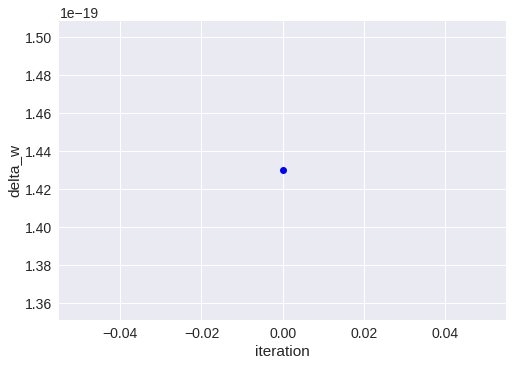

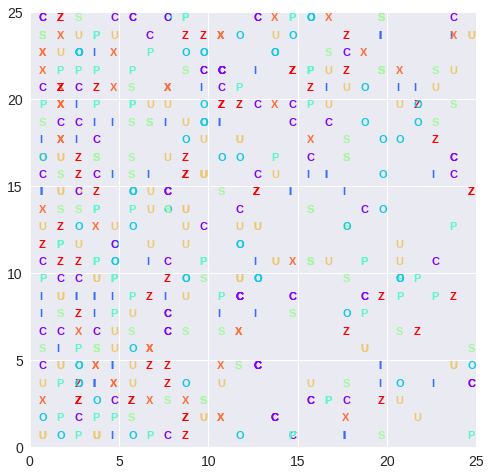

Number of Winning Nodes: 344


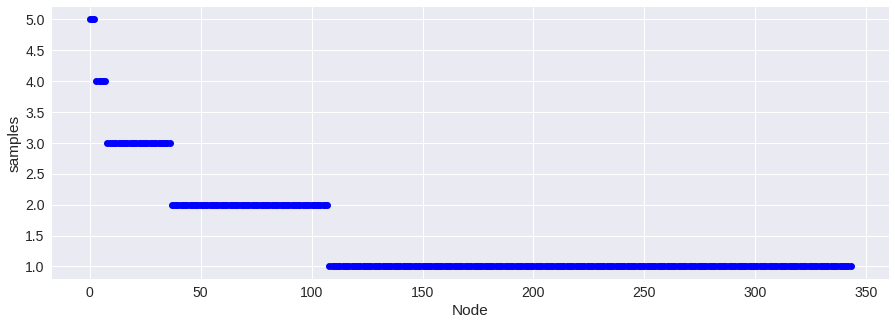

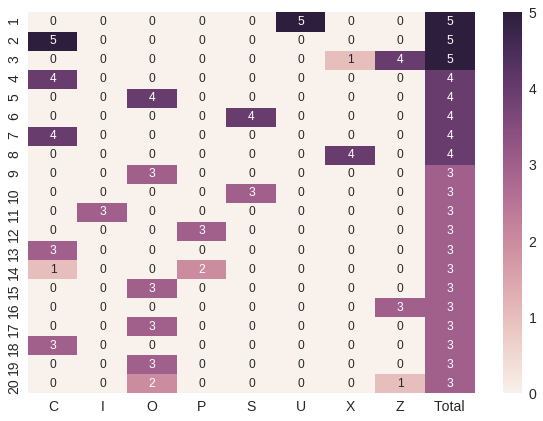

In [8]:
def decay_lr(lr, t, max_iter):
#   return lr * np.exp(-t*0.01)
  return lr / (1+t/(max_iter/2))
  
def decay_sigma(sigma, t, max_iter):
#   return sigma * np.exp(-t*0.01)
  return sigma / (1+t/(max_iter/2))

  
x = 25; y = 25
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 0

#neighborhood='mexican_hat'
#neighborhood='bubble'
#neighborhood='gaussian'
neighborhood='triangle'

somA = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood)
somA._weights = ini_weights
#somA.random_weights_init(alphabet)  # initialize weights with random values 
somA.train_delta(alphabet, delta=0.0001, max_iteration=2000, verbose=True, 
                 decay_lr=decay_lr, 
                 decay_sigma=decay_sigma)

weightsA = somA._weights



# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somA.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weightsA.shape[0], 0,  weightsA.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somA.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
for i in range(len(mappings)):
  plt.plot(i, len(np.flipud(sorted_values)[i]),'bo')
  plt.xlabel('Node')
  plt.ylabel('samples')
  
  
if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()


#Part B

In [0]:
x = 625; y = 1
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 1

#neighborhood='mexican_hat'
#neighborhood='bubble'
neighborhood='gaussian'
#neighborhood='triangle'

somB = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood) 
somB._weights = ini_weights
#somB.random_weights_init(alphabet)  # initialize weights with random values 
somB.train_delta(alphabet, delta=0.0001, max_iteration=2000, verbose=True)

weightsB = somB._weights



# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somB.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weightsB.shape[0], 0,  weightsB.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somB.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
for i in range(len(mappings)):
  plt.plot(i, len(np.flipud(sorted_values)[i]),'bo')
  plt.xlabel('Node')
  plt.ylabel('samples')
  
if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()


#Part C

In [0]:
x = 25; y = 25
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 1

#neighborhood='mexican_hat'
#neighborhood='bubble'
neighborhood='gaussian'
#neighborhood='triangle'

somC = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood) 
somC._weights = ini_weights
#somC.random_weights_init(alphabet)  # initialize weights with random values 
somC.train_delta(alphabet, delta=0.0001, max_iteration=2000, verbose=True)

weightsC = somC._weights



# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somC.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weightsC.shape[0], 0,  weightsC.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somC.win_map(alphabet)
print("Number of Winning Nodes: "+str(len(mappings)))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

plt.figure(figsize=(15, 5))
for i in range(len(mappings)):
  plt.plot(i, len(np.flipud(sorted_values)[i]),'bo')
  plt.xlabel('Node')
  plt.ylabel('samples')

if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1

result_mat = np.flipud(result_mat)

import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()
